In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import h5py
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from keras.models import load_model
import mmap

In [6]:
# Load images and labels from .npy files
all_images = np.load(r'D:\notebooks Lab 5 and 5\all_images.npy', mmap_mode='r')
#all_images = np.load(r'D:/notebooks Lab 5 and 5/face_embeddings.npy', mmap_mode='r')
all_labels = np.load(r'D:\notebooks Lab 5 and 5\all_labels.npy')


In [9]:
all_images.shape

(17431, 224, 224, 3)

In [10]:
all_labels.shape

(17431, 1)

In [11]:

#split data
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2)

# Convert target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=105)
y_test_encoded = to_categorical(y_test, num_classes=105)


In [13]:


# Open the weights file
with h5py.File(r'D:\MODELs\archive (3)\inception_v3_weights_tf_dim_ordering_tf_kernels.h5', "r") as f:
    # Get the keys (layer names)
    layer_names = list(f.keys())
    print(layer_names)

['activation_1', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_2', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_3', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_4', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49', 'activation_5', 'activation_50', 'activation_51', 'activation_52', 'activation_53', 'activation_54', 'activation_55', 'activation_56', 'activation_57', 'activation_58', 'activation_59', 'activation_6', 'activation_60', 'activation_61', 'activation_62', 'a

In [14]:

base_model = InceptionV3(input_shape = (224,224,3),weights=None,include_top = True)

In [15]:

base_model.load_weights(r'D:\MODELS\archive (3)\inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
for layer in base_model.layers:
    layer.trainable = False


In [ ]:

#pre_trained_model.summary()
last_layer = base_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='elu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(105, activation='softmax')(x)
model = Model(base_model.input, x)
learning_rate_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
     initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.8
)
model.compile(optimizer = Adam(learning_rate=learning_rate_schedule),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
# Custom early stopping class
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=5):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.wait = 0
        self.best_accuracy = None  # Track best formatted accuracy as string

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get("val_accuracy")

        if current_accuracy is not None:
            # Convert accuracy to a string with two decimal places without rounding
            formatted_accuracy = "{:.2f}".format(float(str(current_accuracy)[:4]))

            # Initialize best_accuracy if it's the first epoch
            if self.best_accuracy is None:
                self.best_accuracy = formatted_accuracy

            # Check if current accuracy is better than or matches the best accuracy
            if formatted_accuracy > self.best_accuracy:
                self.best_accuracy = formatted_accuracy
                self.wait = 0  # Reset wait counter
            elif formatted_accuracy == self.best_accuracy:
                self.wait += 1  # Increase wait counter if no new improvement
            else:
                self.wait = 0  # Reset if accuracy worsens

            # Stop training if patience is exceeded
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered after {self.wait} epochs without improvement.")
                self.model.stop_training = True

# Create the callback
early_stop = CustomEarlyStopping(patience=5)


In [21]:
# Train the model with both callbacks
history = model.fit(
    x_train,
    y_train_encoded,
    epochs=100,
    validation_data=(x_test, y_test_encoded),
    batch_size=128,
    callbacks=[early_stop]
)


Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 549s 5s/step - accuracy: 0.0444 - loss: 4.8758 - val_accuracy: 0.2724 - val_loss: 3.4027
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 571s 5s/step - accuracy: 0.3394 - loss: 2.9229 - val_accuracy: 0.5030 - val_loss: 2.3142
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 592s 5s/step - accuracy: 0.6251 - loss: 1.7131 - val_accuracy: 0.6169 - val_loss: 1.7987
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.7941 - loss: 1.0325 - val_accuracy: 0.6544 - val_loss: 1.5160
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 597s 5s/step - accuracy: 0.8926 - loss: 0.5958 - val_accuracy: 0.7167 - val_loss: 1.2742
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 557s 5s/step - accuracy: 0.9454 - loss: 0.3716 - val_accuracy: 0.7310 - val_loss: 1.1929
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 594s 5s/step - accuracy: 0.9759 - loss: 0.2366 - val_accuracy: 0.7485 - val_loss: 1.1192
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 594s 5s/step - accuracy: 0.9826 - loss: 0.1776 - 

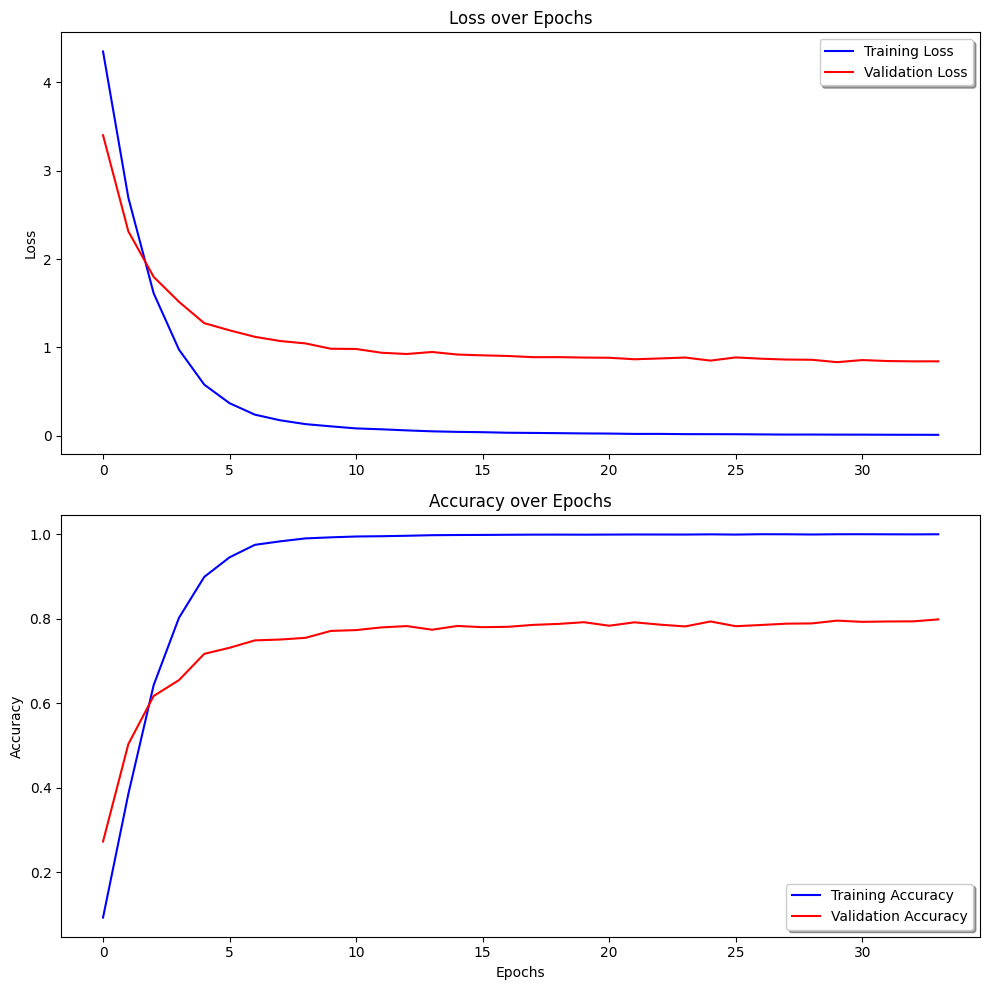

In [22]:

fig, ax = plt.subplots(2, 1, figsize=(10, 10))  # Added figsize for better visualization

# Plot Training and Validation Loss
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
ax[0].set_title("Loss over Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(loc='best', shadow=True)

# Plot Training and Validation Accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].set_title("Accuracy over Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend(loc='best', shadow=True) 

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [23]:




# Evaluate the model on the validation data
evaluation = model.evaluate(x_test, y_test_encoded)

# Extract loss and accuracy from the evaluation
loss = evaluation[0]
accuracy = evaluation[1]

print("Loss on validation data:", loss)
print("Accuracy on validation data:", accuracy)


y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

109/109 ━━━━━━━━━━━━━━━━━━━━ 87s 798ms/step - accuracy: 0.7969 - loss: 0.8207
Loss on validation data: 0.8420204520225525
Accuracy on validation data: 0.7981072664260864
109/109 ━━━━━━━━━━━━━━━━━━━━ 103s 928ms/step
Precision: 0.8121648008561916
Recall: 0.7981072555205048
F1 Score: 0.7987326366383327


c:\Users\Rabab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


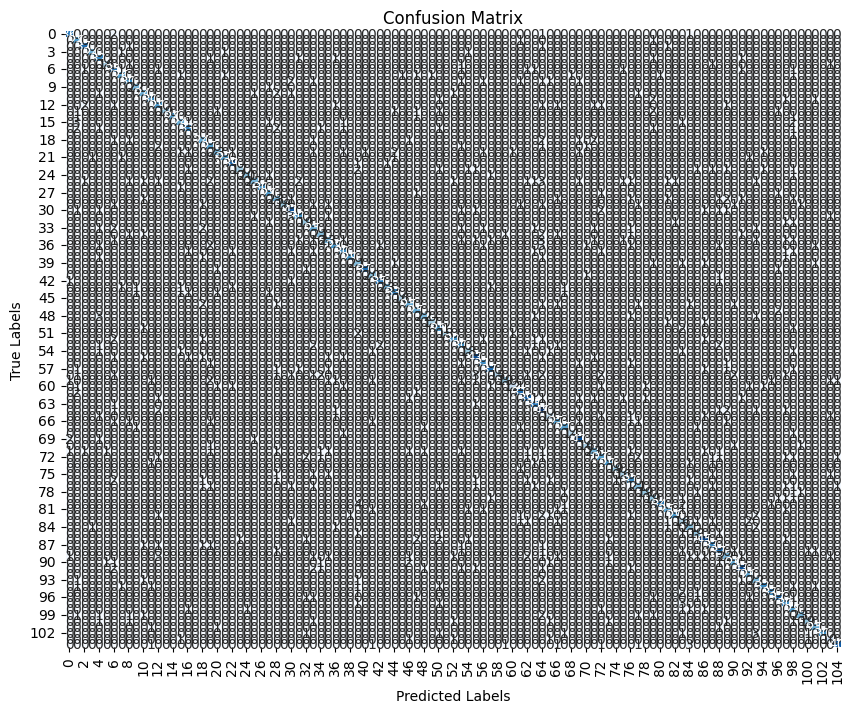

In [24]:

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

Accuracy: 0.7981
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.64      0.93      0.76        30
           2       0.88      0.93      0.90        40
           3       0.92      0.89      0.91        27
           4       0.68      0.86      0.76        37
           5       0.89      0.80      0.84        20
           6       0.64      0.80      0.71        44
           7       0.84      0.76      0.80        34
           8       0.79      0.77      0.78        39
           9       0.88      0.96      0.92        23
          10       0.75      0.77      0.76        31
          11       0.86      0.86      0.86        35
          12       0.69      0.76      0.72        38
          13       1.00      0.70      0.83        27
          14       1.00      0.90      0.95        31
          15       0.77      0.73      0.75        33
          16       0.82      0.77      0.

c:\Users\Rabab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rabab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rabab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [27]:
model.save('D:\MODELs\inception80%.h5')